# Applied Machine Learning Final Project
### By Dean Zruya (207153628) and Emanuel Goldman (315690750)

In [ ]:
import os
import copy
import torch.nn as nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10, EMNIST
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
import scipy.stats as stats
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


######################
eval_mode = False  ###
######################

In [2]:
# define parameters
num_epochs = 100
classification_num_epochs = 50
batch_size = 64
learning_rate = 0.001
positive_inf_int = 10**18  # or any very large value


torch.manual_seed(42)
np.random.seed(42)

# How many samples to generate for running the classifier faster (for the final submission use 60000)
N = 60000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

# We use the mean and standard deviation of the MNIST dataset 
# known as global contrast normalization - https://mint.westdri.ca/ai/pt/pt_mnist

std  = 0.3081
mean = 0.1307

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize([mean], [std])
])

# Get data from torchvision.datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
train_len_original = len(trainset)

train_len = int(train_len_original * 0.8)
val_len = int(train_len_original * 0.2)

NT = int(N * 0.8)
NV = int(N * 0.2)
NTEST = NV

trainset, valset = torch.utils.data.random_split(trainset, [train_len, val_len])


# sample indicies for train set
train_size = len(trainset)
train_idx = np.arange(train_size)
train_subset_idx = np.random.choice(train_idx, NT)
train_subset_sampler = SubsetRandomSampler(train_subset_idx)
train_len_original = len(train_subset_sampler)

# sample indicies for validation set
val_size = len(valset)
val_idx = np.arange(val_size)
val_subset_idx = np.random.choice(val_idx, NV)
val_subset_sampler = SubsetRandomSampler(val_subset_idx)
val_len_original = len(val_subset_sampler)


# sample indicies for test set
test_size = len(testset)
test_idx = np.arange(test_size)
test_subset_idx = np.random.choice(test_idx, NTEST)
test_subset_sampler = SubsetRandomSampler(test_subset_idx)
test_len_original = len(test_subset_sampler)



print("Train set size sample len: ", train_subset_idx.shape[0])
print("Validation set size sample len: ", val_subset_idx.shape[0])



# set sampler for trainset - note: no shuffle argument when sampler is provided
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_subset_sampler)

valloader = DataLoader(valset, batch_size=batch_size, sampler=val_subset_sampler)

testloader = DataLoader(testset, batch_size=batch_size, sampler=test_subset_sampler)



Train set size sample len:  48000
Validation set size sample len:  12000


### Models

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.code_size = 64
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.BatchNorm1d(256),  # BatchNorm added
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, self.code_size)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, 64),
            nn.ReLU(True),
            nn.BatchNorm1d(64),  # Batch normalization added
            nn.Dropout(0.2),  
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.BatchNorm1d(128),  # Batch normalization added
            nn.Dropout(0.2),  
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),  # Batch normalization added

            nn.Linear(256, 28 * 28)
        )


    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        return recon, encoded_vector

In [6]:
class Baseline_MTAE(autoencoder):
    def __init__(self):
        # inhert from parent
        super(Baseline_MTAE, self).__init__()
        self.n_classes = 10
        # Add classification head
        self.clf = nn.Sequential(
            nn.Linear(self.code_size, 32),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(32, self.n_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        preds = self.clf(encoded_vector)
        return recon, preds, encoded_vector

In [7]:
class MTAE_OOD(Baseline_MTAE):
    def __init__(self):
        super(MTAE_OOD, self).__init__()
        self.threshold = None

        # Increase number of output classes (10 known + 1 OOD)
        self.n_classes = 11  
        self.clf = nn.Sequential(
            nn.Linear(self.code_size, self.n_classes),
            nn.LogSoftmax(dim=1)  # Ensures output is valid for NLLLoss
        )

    def forward(self, x, model_in_eval_mode=False):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        preds = self.clf(encoded_vector)

        if model_in_eval_mode:
            # Reconstruction loss
            loss = nn.MSELoss(reduction='none')
            loss = loss(recon, x)
            loss = loss.sum(dim=1)
            recon_error = loss

            # If error is above threshold, classify as OOD
            preds[recon_error > self.threshold, -1] = 10
        
        return recon, preds, encoded_vector
    
    def set_threshold(self, threshold):
        self.threshold = threshold

    def get_threshold(self):
        return self.threshold

### Training
**Reconstruction loss:** We will compute the Mean-squared error (MSE) between the reconstructed images and the original ones.

**Classification loss:** If ML-AE is chosen, we will also compute the NLL between the class labels and the classification head predictions

In [8]:
def create_and_train_model(num_epochs, final_m=False) -> MTAE_OOD:
    criterion = nn.MSELoss()
    clf_criterion = nn.NLLLoss()

    if final_m:
        model = MTAE_OOD().to(device)
    else:
        model = Baseline_MTAE().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    loss_train_ae = []
    loss_train_clf = []
    loss_val_ae = []
    loss_val_clf = []

    for epoch in tqdm(range(num_epochs)):
        model.train()

        # **Freeze classification head after epoch classification_num_epochs**
        if epoch < classification_num_epochs:
            for param in model.clf.parameters():
                param.requires_grad = False

        loss_ae_epoch = 0
        loss_clf_epoch = 0

        for data in trainloader:
            optimizer.zero_grad()
            img, labels = data
            img = img.view(img.size(0), -1).to(device)
            labels = labels.to(device)

            recon, preds, embeddings = model(img)

            loss_ae_batch = criterion(recon, img)

            # **Only compute classification loss if clf is not frozen**
            if epoch > classification_num_epochs:
                loss_clf_batch = clf_criterion(preds, labels)
                loss = loss_ae_batch + loss_clf_batch
                loss_clf_epoch += loss_clf_batch.item()
            else:
                loss = loss_ae_batch  # Stop using classification loss

            loss.backward()
            optimizer.step()

            loss_ae_epoch += loss_ae_batch.item()

        loss_train_ae.append(loss_ae_epoch / len(trainloader))
        loss_train_clf.append(loss_clf_epoch / len(trainloader) if epoch > classification_num_epochs else 0)

        # **VALIDATION STEP**
        model.eval()
        val_loss_ae_epoch = 0
        val_loss_clf_epoch = 0

        with torch.no_grad():
            for val_data in valloader:
                img, labels = val_data
                img = img.view(img.size(0), -1).to(device)
                labels = labels.to(device)

                recon, preds, embeddings = model(img)

                val_loss_ae_epoch += criterion(recon, img).item()

                if epoch > classification_num_epochs:
                    val_loss_clf_epoch += clf_criterion(preds, labels).item()

        loss_val_ae.append(val_loss_ae_epoch / len(valloader))
        loss_val_clf.append(val_loss_clf_epoch / len(valloader) if epoch > classification_num_epochs else 0)

    #### **Plot losses**
    plt.plot(loss_train_ae, label="Reconstruction loss")
    plt.plot(loss_train_clf, label="Classification loss")
    plt.plot(loss_val_ae, label="Validation Reconstruction loss", linestyle="dashed")
    plt.plot(loss_val_clf, label="Validation Classification loss", linestyle="dashed")

    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.title("AE Training Loss")
    plt.show()

    return model


In [9]:
%%time

if eval_mode:
    # Load the baseline model
    baseline_model = MTAE_OOD().to(device)
    state_dict = torch.load(os.path.join("models", "baseline_model.pth"), weights_only=True)
    baseline_model.load_state_dict(state_dict)
    baseline_model.set_threshold(positive_inf_int)

    # Load the final model
    final_model = MTAE_OOD().to(device)
    state_dict = torch.load(os.path.join("models", "final_model.pth"), weights_only=True)
    final_model.load_state_dict(state_dict)
    final_model.set_threshold(344.6019124952895)



else:
    # Train the model
    baseline_model = create_and_train_model(num_epochs, final_m=True)

    # copy model for final one.
    final_model = copy.deepcopy(baseline_model)

    # set the baseline model with inf threashold
    baseline_model.set_threshold(positive_inf_int)

    # Save the model
    torch.save(baseline_model.state_dict(), os.path.join('models', 'baseline_model.pth'))



CPU times: total: 78.1 ms
Wall time: 87.5 ms


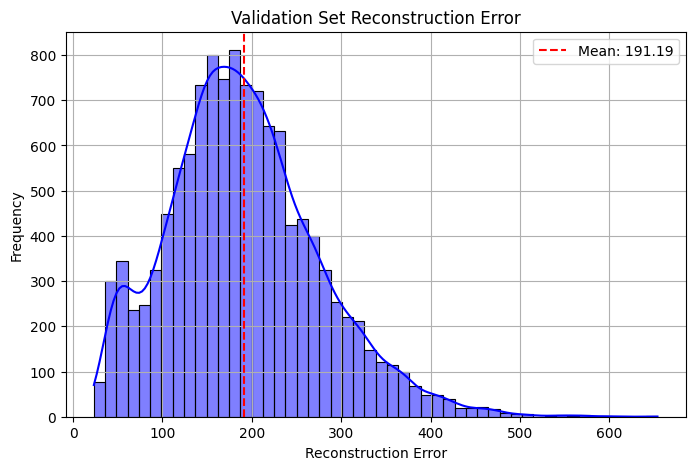

90th percentile: 302.30


In [10]:
def reconstruction_uncertainty(model, dataloader, device):
    model.eval()
    uncertainties = []

    def plot_uncertainty_distribution(uncertainties, title="Reconstruction Uncertainty Distribution"):
        plt.figure(figsize=(8, 5))
        sns.histplot(uncertainties, bins=50, kde=True, color="blue")
        plt.axvline(np.mean(uncertainties), color='red', linestyle='dashed', label=f"Mean: {np.mean(uncertainties):.2f}")
        plt.xlabel("Reconstruction Error")
        plt.ylabel("Frequency")
        plt.title(title)
        plt.legend()
        plt.grid()
        plt.show()

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            recon, preds, encoded_vector = model(images)

            # Reconstruction loss
            loss = nn.MSELoss(reduction='none')
            loss = loss(recon, images)
            loss = loss.sum(dim=1)
            uncertainties.extend(loss.cpu().numpy())

    plot_uncertainty_distribution(uncertainties, title="Validation Set Reconstruction Error")

    return uncertainties


uncertenties = reconstruction_uncertainty(final_model, valloader, device)

# plot_uncertainty_distribution(uncertenties, title="Validation Set Reconstruction Error")

threshold_for_evt = np.percentile(uncertenties, 90)
print(f"90th percentile: {threshold_for_evt:.2f}")

In [11]:
uncertainties_tail = [x for x  in uncertenties if x > threshold_for_evt]

# Fit the GPD to the extracted tail data
shape, loc, scale = stats.genpareto.fit(uncertainties_tail)

print(f"Shape (ξ): {shape}, Scale (σ): {scale}")

Shape (ξ): -0.21758992372822505, Scale (σ): 78.47358201131595


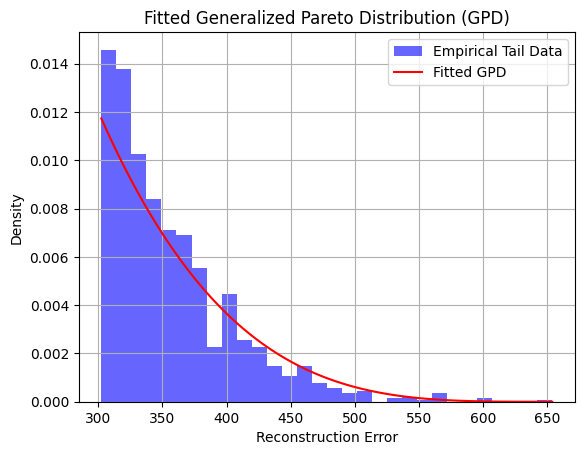

In [12]:
from scipy.stats import genpareto

# Generate the x values for plotting
x = np.linspace(min(uncertainties_tail), max(uncertainties_tail), 100)

# Compute the GPD PDF (Probability Density Function)
pdf = genpareto.pdf(x, shape, loc=loc, scale=scale)

# Plot histogram of tail data
plt.hist(uncertainties_tail, bins=30, density=True, alpha=0.6, color='b', label="Empirical Tail Data")

# Plot the fitted GPD curve
plt.plot(x, pdf, 'r-', label="Fitted GPD")

# Labels and legend
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Fitted Generalized Pareto Distribution (GPD)")
plt.legend()
plt.grid()

plt.show()


In [13]:
quantile = 0.50  # 50% confidence threshold

# Compute the EVT-based threshold
ev_threshold = stats.genpareto.ppf(quantile, shape, loc, scale)

print(f"EVT-Based Threshold: {ev_threshold}")

EVT-Based Threshold: 344.6019124952895


In [14]:
final_model.set_threshold(ev_threshold)

# Save the model
torch.save(final_model.state_dict(), os.path.join('models', 'final_model.pth'))

In [15]:
# Evaluate on test set
def evaluate_model(model, dataloader, final_m=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            if final_m:
                recon, preds, encoded_vector = model(images, model_in_eval_mode=True)
            else:
                recon, preds, encoded_vector = model(images)
            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


# Evaluate the baseline model
eval_train_baseline = evaluate_model(baseline_model, trainloader)
eval_val_baseline = evaluate_model(baseline_model, valloader)

print(f"Baseline Model - Train Accuracy: {eval_train_baseline:.2f}%")
print(f"Baseline Model - Validation Accuracy: {eval_val_baseline:.2f}%")


# Evaluate the final model
eval_train_final = evaluate_model(final_model, trainloader)
eval_val_final = evaluate_model(final_model, valloader)

print(f"Final Model - Train Accuracy: {eval_train_final:.2f}%")
print(f"Final Model - Validation Accuracy: {eval_val_final:.2f}%")

Baseline Model - Train Accuracy: 99.92%
Baseline Model - Validation Accuracy: 97.82%
Final Model - Train Accuracy: 95.38%
Final Model - Validation Accuracy: 93.51%


In [16]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10

In [17]:
### Load CIFAR10 as out-of-distribution (OOD) data.
cif_mean = 0.4838
cif_std = 0.2387

transform_cifar10 = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([cif_mean], [cif_std])
])


# Load the CIFAR10 dataset from PyTorch
cifar = CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform_cifar10,
    target_transform = lambda x: 10
)

# Create a DataLoader for the CIFAR10 dataset
cifar10_dataloader = DataLoader(cifar, batch_size=1024, shuffle=True)

# Display the shape of the CIFAR10 dataset
print("CIFAR10 dataset shape: ", cifar.data.shape)

labels = [cifar[i][1] for i in range(10)]
print("First 10 labels:", labels)

Files already downloaded and verified
CIFAR10 dataset shape:  (50000, 32, 32, 3)
First 10 labels: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [18]:
### Load FashionMNIST as out-of-distribution (OOD) data.

fashion_mean = 0.2860
fashion_std = 0.3530

transform_fashion = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([fashion_mean], [fashion_std])
])

# Load the FashionMNIST dataset from PyTorch
fashion = EMNIST(
    root="./data",
    split="letters",
    train=True,
    download=True,
    transform=transform_fashion,
    target_transform = lambda x: 10
)


# Create a DataLoader for the FashionMNIST dataset
fashion_dataloader = DataLoader(fashion, batch_size=64, shuffle=True)

# Display the shape of the FashionMNIST dataset
print("FashionMNIST dataset shape: ", fashion.data.shape)

labels = [fashion[i][1] for i in range(10)]
print("First 3 labels:", labels)

FashionMNIST dataset shape:  torch.Size([124800, 28, 28])
First 3 labels: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [19]:
def eval_model(model, data_loader, device):
    """ Evaluation function for the OSR task. 
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both. 
    Note - this function does NOT computes the MNIST baseline accruacy. 
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """
    
    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            
            ### Modify output if needed ###
            data = data.view(-1, 28*28)
            # Model outputs
            outputs = model(data, model_in_eval_mode=True)


            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here. 
            
            # Assuming the model returns an (N_batch, 11) size output
            _, y_pred = torch.max(outputs[1], 1)  # Select preds (classification output)
            	    
            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot! 
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]
            
            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)

            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    
    if total_ood != 0:
        acc_ood = correct_ood / total_ood
    else:
        acc_ood = 1
        
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total



In [20]:
from torch.utils.data import Subset
import numpy as np

def create_combined_dataset(ood_ds, mnist_ds, ood_size, mnist_size):
    # Sample indices for OOD dataset
    if ood_size != 0:
        ood_indices = np.random.choice(len(ood_ds), ood_size, replace=False)
        ood_subset = Subset(ood_ds, ood_indices)
    else:
        ood_subset = ood_ds

    # Sample indices for MNIST dataset
    mnist_indices = np.random.choice(len(mnist_ds), mnist_size, replace=False)
    mnist_subset = Subset(mnist_ds, mnist_indices)
    res = CombinedDataset(mnist_subset, ood_subset)
    return res

combined_ds = create_combined_dataset(fashion, testset, 1000, 10000)


In [21]:
# large batchsize for inference is recommended
data_loader = DataLoader(combined_ds, batch_size=batch_size, shuffle=True)


# Placeholder model
model = final_model
model.to(device)

acc_mnist, acc_ood, acc_total = eval_model(model, data_loader, device)

print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')


MNIST Accuracy: 94.39%
OOD Accuracy: 83.00%
Total Accuracy: 93.35%


In [22]:
### Evaluation on "osr dataset"

# Load the baseline model
baseline_model = MTAE_OOD().to(device)
state_dict = torch.load(os.path.join("models", "baseline_model.pth"), weights_only=True)
baseline_model.load_state_dict(state_dict)
baseline_model.set_threshold(positive_inf_int)

# Load the final model
final_model = MTAE_OOD().to(device)
state_dict = torch.load(os.path.join("models", "final_model.pth"), weights_only=True)
final_model.load_state_dict(state_dict)
final_model.set_threshold(344.6019124952895)


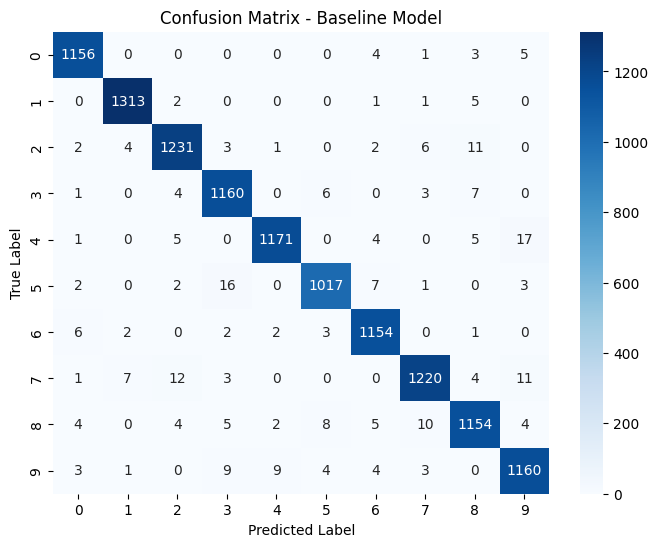

Baseline Model Accuracy: 97.80%


In [23]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_baseline(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            _, preds, _ = model(images)  # Get predictions from the model
            predicted_labels = torch.argmax(preds, dim=1)

            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Baseline Model")
    plt.show()

    return accuracy, cm

# Run evaluation
baseline_accuracy, baseline_cm = evaluate_baseline(baseline_model, testloader, device)

print(f"Baseline Model Accuracy: {baseline_accuracy:.2f}%")


Our OSR approach combines an autoencoder and Extreme Value Theory (EVT) for OOD detection:

 - Autoencoder Feature Learning – Trained on in-distribution (MNIST), reconstruction errors signal OOD samples.
 - Classification with OOD Class – An extra output class (label 10) is added, trained alongside reconstruction.
 - EVT-based Thresholding – A Generalized Pareto Distribution (GPD) models extreme errors, dynamically setting a threshold.
 - Final OOD Decision – A sample is OOD if its reconstruction error exceeds the EVT threshold or its classifier confidence for label 10 is >70%.
 - This method enhances OOD detection by leveraging feature learning, statistical thresholding, and classification synergy


OOD Binary Classification Accuracy: 94.84%
MNIST Classification Accuracy: 94.39%
OOD Classification Accuracy: 83.00%
Total Accuracy: 93.35%


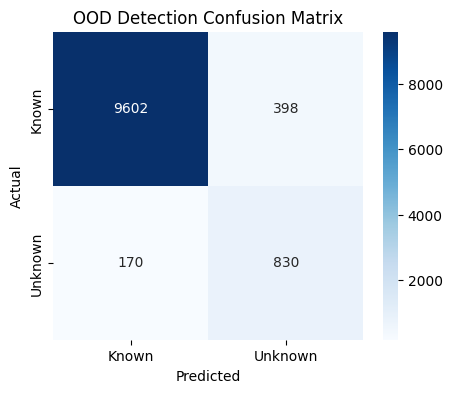

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_ood(model, dataloader, device):
    """Evaluate OOD performance, computing binary classification accuracy and a confusion matrix."""
    
    model.eval()
    
    y_true = []
    y_pred = []

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Flatten images if needed
            images = images.view(images.size(0), -1)

            # Forward pass
            recon, preds, encoded_vector = model(images, model_in_eval_mode=True)
            preds = torch.argmax(preds, dim=1)  # Get predicted class

            # **Map predictions & labels for binary classification**
            preds_binary = (preds == 10).int()  # OOD (10) -> 1, MNIST (0-9) -> 0
            labels_binary = (labels >= 10).int()  # Ground truth OOD labels (>=10) -> 1, MNIST -> 0

            y_true.extend(labels_binary.cpu().numpy())
            y_pred.extend(preds_binary.cpu().numpy())

            # **Track MNIST and OOD accuracy separately**
            mask_mnist = labels < 10
            mask_ood = labels >= 10

            correct_mnist += (preds[mask_mnist] == labels[mask_mnist]).sum().item()
            total_mnist += mask_mnist.sum().item()

            correct_ood += (preds[mask_ood] == labels[mask_ood]).sum().item()
            total_ood += mask_ood.sum().item()

    # **Compute accuracy metrics**
    acc_mnist = correct_mnist / total_mnist if total_mnist > 0 else 0
    acc_ood = correct_ood / total_ood if total_ood > 0 else 0
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    # **Compute binary OOD classification accuracy**
    binary_accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOOD Binary Classification Accuracy: {binary_accuracy:.2%}")
    print(f"MNIST Classification Accuracy: {acc_mnist:.2%}")
    print(f"OOD Classification Accuracy: {acc_ood:.2%}")
    print(f"Total Accuracy: {acc_total:.2%}")

    # **Plot Confusion Matrix**
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Known", "Unknown"], yticklabels=["Known", "Unknown"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("OOD Detection Confusion Matrix")
    plt.show()

    return acc_mnist, acc_ood, acc_total


# **Run the evaluation**
acc_mnist, acc_ood, acc_total = evaluate_ood(model, data_loader, device)



Total OSR Classification Accuracy: 93.35%


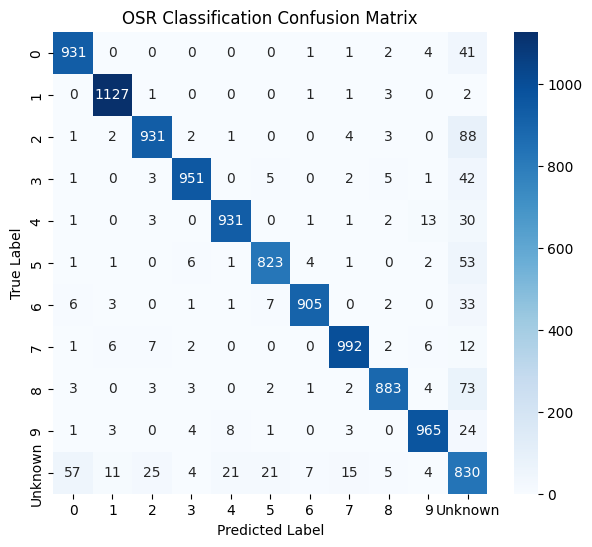

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_osr(model, dataloader, device):
    """Evaluates OSR task: total accuracy for MNIST (0-9) + OOD (10) and plots a confusion matrix."""
    
    model.eval()
    
    y_true = []
    y_pred = []

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Flatten images if needed
            images = images.view(images.size(0), -1)

            # Forward pass
            recon, preds, encoded_vector = model(images, model_in_eval_mode=True)
            preds = torch.argmax(preds, dim=1)  # Get predicted class

            # Append results for accuracy and confusion matrix
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            # Compute total accuracy
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # **Compute total classification accuracy across all 11 classes**
    acc_total = correct / total if total > 0 else 0
    print(f"\nTotal OSR Classification Accuracy: {acc_total:.2%}")

    # **Plot Confusion Matrix**
    cm = confusion_matrix(y_true, y_pred, labels=list(range(11)))  # 11 classes (0-9 + OOD=10)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)] + ["Unknown"], 
                yticklabels=[str(i) for i in range(10)] + ["Unknown"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("OSR Classification Confusion Matrix")
    plt.show()

    return acc_total


# **Run OSR Evaluation**
acc_total = evaluate_osr(model, data_loader, device)


### t-SNE Visualization of MNIST and OOD Data

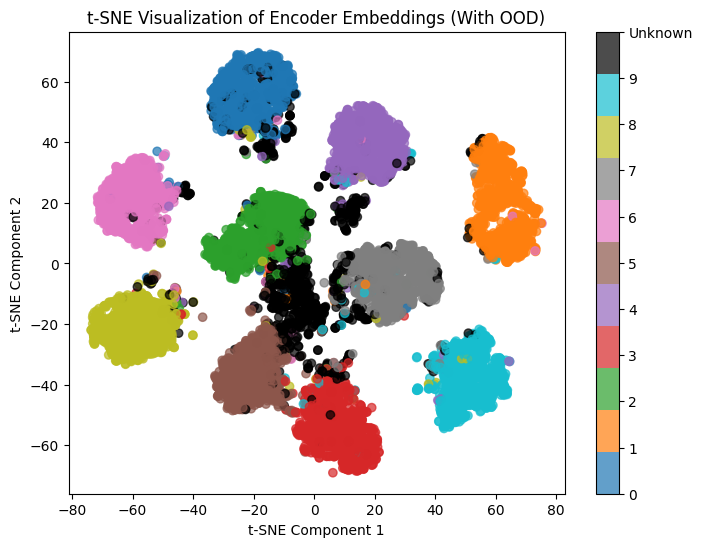

In [26]:
def plot_embeddings_tsne(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device).view(images.size(0), -1)
            _, preds, encoded_vector = model(images)  # Get embeddings

            preds = torch.argmax(preds, dim=1).cpu().numpy()
            targets = targets.cpu().numpy() 

            embeddings.append(encoded_vector.cpu().numpy())
            labels.extend(targets)  

    embeddings = np.concatenate(embeddings, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=min(50, len(embeddings) - 1), random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Custom colormap: Use tab10 for 0-9, and black for OOD (10)
    from matplotlib.colors import ListedColormap
    tab10_colors = plt.get_cmap("tab10").colors  # Get tab10 colors
    custom_colors = list(tab10_colors[:10]) + ["black"]  # Append black for class 10 (Unknown)
    cmap = ListedColormap(custom_colors)

    # Plot with custom colors
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap=cmap, alpha=0.7)
    cbar = plt.colorbar(scatter)
    cbar.set_ticks(range(11))  # Ensure OOD (10) is labeled
    cbar.set_ticklabels([str(i) for i in range(10)] + ["Unknown"])  

    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Visualization of Encoder Embeddings (With OOD)")
    plt.show()

# Run the function
plot_embeddings_tsne(model, data_loader, device)


In this visualization, we applied t-SNE to reduce the high-dimensional encoder embeddings to 2D, allowing us to observe their structure.<br>
Each color represents a digit class (0-9) from MNIST, while the black points correspond to OOD (Out-of-Distribution) samples.<br>
We ensured proper label mapping so that the OOD class (10) is distinctly represented in black.<br>
The clusters indicate that the encoder effectively separates digit classes, while OOD samples are spread across different regions,<br>
showing where the model struggles to distinguish them.<br>
This insight helps evaluate how well the model differentiates known and unknown data, guiding improvements for OOD detection.


In [27]:
from torch.utils.data import TensorDataset
import torch

# Load MNIST test set
mnist_test = testset

# Create a placeholder dataset for OSR (OOD samples)
osr_dataset = TensorDataset(torch.empty(0, 1, 28, 28), torch.empty(0, dtype=torch.long))  # No samples yet

# Combine datasets
combined_dataset = create_combined_dataset(osr_dataset, mnist_test, len(osr_dataset), len(mnist_test))

# Create DataLoader
osr_dataloader = DataLoader(combined_dataset, batch_size=1024, shuffle=False)

final_model.to(device)

acc_mnist, acc_ood, acc_total = eval_model(model, osr_dataloader, device)

print(f'MNIST Accuracy: {acc_mnist*100:.2f}%')
print(f'OOD Accuracy: {acc_ood*100:.2f}%')
print(f'Total Accuracy: {acc_total*100:.2f}%')


MNIST Accuracy: 94.39%
OOD Accuracy: 100.00%
Total Accuracy: 94.39%


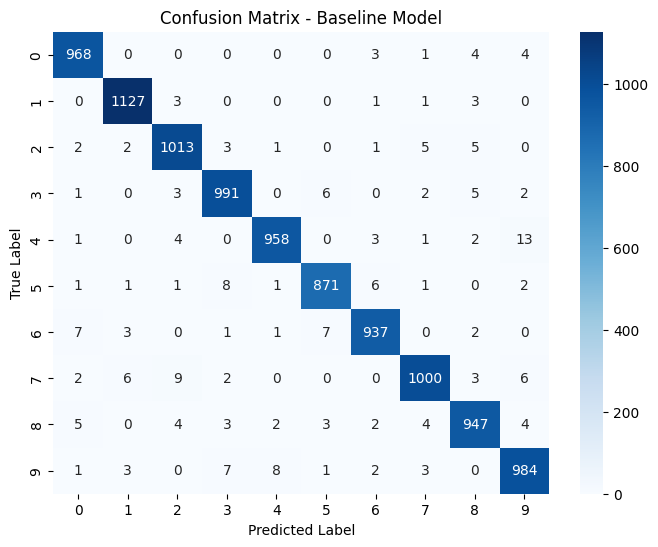

Baseline Model Accuracy: 97.96%


In [28]:
# Run evaluation
baseline_accuracy, baseline_cm = evaluate_baseline(baseline_model, osr_dataloader, device)

print(f"Baseline Model Accuracy: {baseline_accuracy:.2f}%")


OOD Binary Classification Accuracy: 96.02%
MNIST Classification Accuracy: 94.39%
OOD Classification Accuracy: 0.00%
Total Accuracy: 94.39%


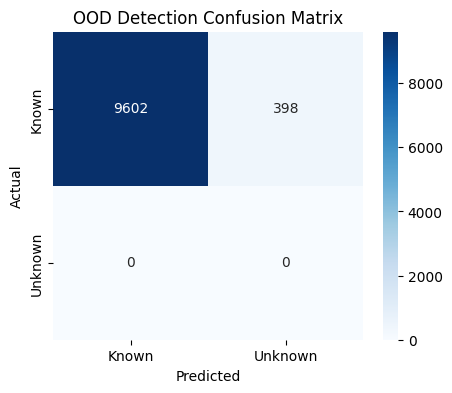

In [29]:
# **Run the evaluation**
acc_mnist, acc_ood, acc_total = evaluate_ood(model, osr_dataloader, device)


Total OSR Classification Accuracy: 94.39%


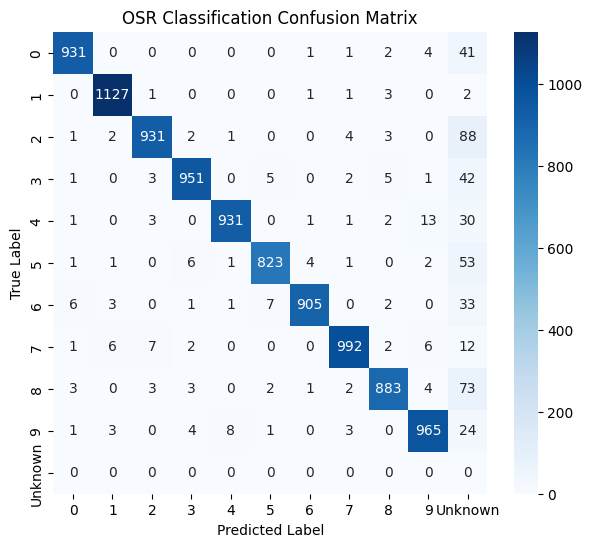

In [30]:
# **Run OSR Evaluation**
acc_total = evaluate_osr(model, osr_dataloader, device)

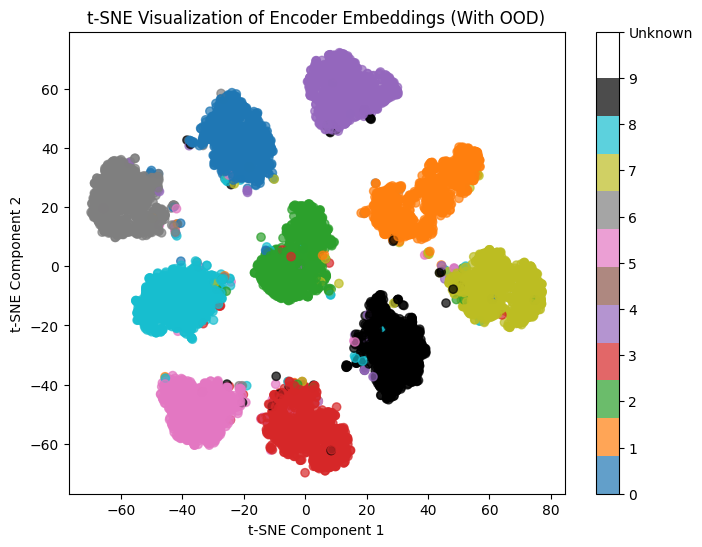

In [31]:
plot_embeddings_tsne(model, osr_dataloader, device)